In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('data.csv')

In [10]:
#select only two columns and make new df
df2=df[['review_text','review_rating']]

In [31]:
df2.shape

(2501, 2)

In [64]:
import requests


inputs=[]
inputstosend=[]
responses=[]
start=0
for col in df2['review_text']:
    inputs.append(col)

#make list containing 100 each
for i in range(0,len(inputs),100):
    inputstosend.append(inputs[i:i+100])

#1024 dimentional vector
url = "https://api.ai21.com/studio/v1/embed"

for i in range(len(inputstosend)):
    payload = { "texts": inputstosend[i] }
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "Authorization": f"BEARER {ai21apikey}"
    }

    response = requests.post(url, json=payload, headers=headers)
    responses.append(response.json())

# payload = { "texts": ["hi","hello"] }
# headers = {
#     "accept": "application/json",
#     "content-type": "application/json",
#     "Authorization": f"BEARER {ai21apikey}"
# }

# response = requests.post(url, json=payload, headers=headers)


# print(response.json()['results'][0]['embedding'])
# print(response.json()['results'][1]['embedding'])


In [71]:
#make df from the embeddings
responsemmbeddings=[]
for i in range(len(responses)):
    for j in range(len(responses[i]['results'])):
        responsemmbeddings.append(responses[i]['results'][j]['embedding'])



In [5]:
responsemmbeddingsdf=pd.read_csv('embeddings.csv')

In [6]:
responsemmbeddingsdf.shape

(2501, 1025)

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import sklearn
from sklearn.model_selection import train_test_split


In [8]:
Y=responsemmbeddingsdf['rating']
X=responsemmbeddingsdf.drop(columns=['rating'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [9]:
Y.unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [10]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu',input_shape=(X_train.shape[1],)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 3,412,229
Trainable params: 3,412,229
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',      
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Convert the labels to be within the valid range
y_train = y_train - 1
y_test = y_test - 1

In [14]:


# Retrain the model with the updated labels
trained_model = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
63/63 [==============================] - 4s 56ms/step - loss: 0.7742 - accuracy: 0.7420 - val_loss: 0.6214 - val_accuracy: 0.7565
Epoch 2/10
63/63 [==============================] - 3s 45ms/step - loss: 0.6042 - accuracy: 0.7790 - val_loss: 0.5981 - val_accuracy: 0.7844
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.5533 - accuracy: 0.7870 - val_loss: 0.6202 - val_accuracy: 0.7844
Epoch 4/10
63/63 [==============================] - 3s 50ms/step - loss: 0.5167 - accuracy: 0.8010 - val_loss: 0.5738 - val_accuracy: 0.7625
Epoch 5/10
63/63 [==============================] - 3s 50ms/step - loss: 0.4756 - accuracy: 0.8175 - val_loss: 0.5276 - val_accuracy: 0.7884
Epoch 6/10
63/63 [==============================] - 3s 45ms/step - loss: 0.4615 - accuracy: 0.8225 - val_loss: 0.5968 - val_accuracy: 0.8064
Epoch 7/10
63/63 [==============================] - 3s 45ms/step - loss: 0.4450 - accuracy: 0.8335 - val_loss: 0.5137 - val_accuracy: 0.8124
Epoch 8/10
63

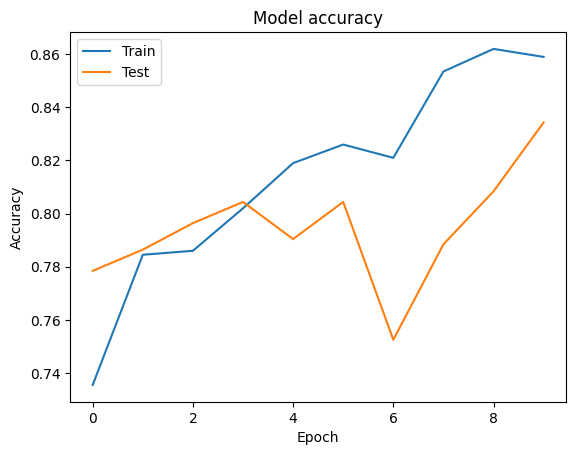

In [18]:
#plot accuray and loss
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
#save as h5
model.save('reviewsmodel.h5')
